# ScMeMo preserves marker correlations through further downsampling
Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [3]:
%matplotlib inline

In [7]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
from sklearn.decomposition import PCA

In [11]:
from sklearn.preprocessing import StandardScaler

In [14]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
#sys.path.append('/wynton/group/ye/mincheol/Github/scrna-parameter-estimation/simplesc')

import scmemo, utils

In [21]:
data_path = '/data/parameter_estimation/interferon_data/20200324/'
#data_path = '/wynton/group/ye/mincheol/parameter_estimation/interferon_data/20191218/'


### Plotting function

In [22]:
def plot_2d_discrete(data, size_multiplier=10, offset=0.0):
    """ Plotting discrete 2D data according to the frequency. """
    
    df = pd.DataFrame(data).groupby([0, 1]).size().reset_index(name='count')
    df['log_count'] = np.log(df['count'])
    
    plt.scatter(df[0]+offset, df[1]+offset, s=df['log_count']*size_multiplier)    
    

### Read the IFN AnnData object

In [75]:
ifn_adata = sc.read(data_path + 'interferon_highcount.raw.h5ad')
ifn_adata = ifn_adata[:, ifn_adata.var.index.map(lambda x: x[:2] != 'HB')]
ifn_adata.obs['cell_type'] = (ifn_adata.obs['cell'].astype(str) + ' - ' + ifn_adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


### Marker gene correlation maps

In [77]:
marker_genes = [
    'GNLY', 'NKG7', 'PRF1', 'GZMA', 'GZMB', 'RARRES3',
    'IL7R', 'CD3G', 'CD3D', 'CD3E', 'LCK',
    'CD79A', 'CD79B','MS4A1', 'BANK1', 
    'PF4', 'PPBP',
    'FCGR3A', 'MS4A7', 
    'CD14', 'LYZ', 'S100A9', 'S100A8',
]

In [78]:
full_ifn_adata = sc.read(data_path + 'interferon.h5ad')
full_ifn_adata.obs['n_counts'] = full_ifn_adata.X.sum(axis=1)

In [79]:
marker_gene_adata = full_ifn_adata[:, marker_genes].copy()
marker_gene_adata.X = marker_gene_adata.X.toarray()
marker_gene_adata.obs['PBMC'] = 'Y'

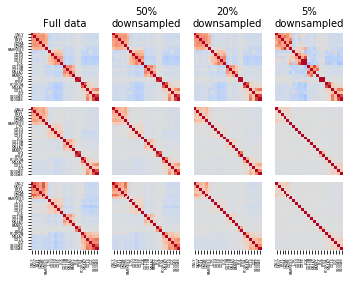

In [117]:
plt.figure(figsize=(6, 4));
plt.subplots_adjust(hspace=0.1, wspace=-0.1)

params = {
    'figure.titlesize':6,
    'xtick.labelsize':3.5,
    'ytick.labelsize':3.5}
pylab.rcParams.update(params)

for idx, dropout in enumerate([1, 0.5, 0.2, 0.05]):
    #dropout = 0.05

    full_ifn_adata_sampled = full_ifn_adata.copy()
    #full_ifn_adata_sampled.X = full_ifn_adata_sampled.X.toarray().astype(int)

    ifn_adata_sampled = ifn_adata.copy()
    ifn_adata_sampled.X = ifn_adata_sampled.X.toarray().astype(int)
    ifn_adata_sampled.X = stats.binom.rvs(ifn_adata_sampled.X, p=dropout)

    # Compute the 3k gene dataset to compute q^2
    all_gene_estimator = scmemo.SingleCellEstimator(
        adata=ifn_adata_sampled, 
        group_label='cell',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.1*dropout)
    all_gene_estimator.compute_observed_moments()
    all_gene_estimator.estimate_beta_sq(tolerance=5)
    
    # Prepare the marker gene AnnData object
    marker_gene_adata_sampled = full_ifn_adata[:, marker_genes].copy()
    marker_gene_adata_sampled.X = marker_gene_adata_sampled.X.toarray().astype(int)
    marker_gene_adata_sampled.X = stats.binom.rvs(marker_gene_adata_sampled.X, p=dropout)
    marker_gene_adata_sampled.obs['PBMC'] = 'Y'
    marker_gene_adata_sampled_norm = marker_gene_adata_sampled.copy()
    marker_gene_adata_sampled_norm.X = marker_gene_adata_sampled_norm.X / (dropout * marker_gene_adata_sampled_norm.obs['n_counts'].values).reshape(-1, 1)*1e4
    sc.pp.log1p(marker_gene_adata_sampled_norm)
    
    # Estimate using scMeMo using the q^2 computed above
    estimator = scmemo.SingleCellEstimator(
        adata=marker_gene_adata_sampled, 
        group_label='PBMC',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.1*dropout)
    estimator.compute_observed_moments()
    estimator.beta_sq = all_gene_estimator.beta_sq
    estimator.estimate_1d_parameters()
    estimator.estimate_2d_parameters(
        gene_list_1=marker_genes,
        gene_list_2=marker_genes)

    # Fit a correlation matrix
    estimated_corr_mat = estimator.parameters['Y']['corr'].toarray()
    estimated_corr_mat = np.clip(estimated_corr_mat, -1, 1)
    raw_corr_mat = np.corrcoef(marker_gene_adata_sampled.X, rowvar=False)
    norm_corr_mat = np.corrcoef(marker_gene_adata_sampled_norm.X, rowvar=False)
    estimated_corr_mat = pd.DataFrame(estimated_corr_mat, index=marker_genes, columns=marker_genes)
    raw_corr_mat = pd.DataFrame(raw_corr_mat, index=marker_genes, columns=marker_genes)
    norm_corr_mat = pd.DataFrame(norm_corr_mat, index=marker_genes, columns=marker_genes)

    plt.subplot(3, 4, idx + 1);
    sns.heatmap(estimated_corr_mat, cmap='coolwarm', cbar=False,
        xticklabels=False, yticklabels=False if idx > 0 else True, center=0, square=True)
    plt.title('{}%\ndownsampled'.format(int(dropout*100)) if dropout < 1 else 'Full data')
    
    plt.subplot(3, 4, idx + 5);
    sns.heatmap(raw_corr_mat, cmap='coolwarm',cbar=False,
        xticklabels=False, yticklabels=False if idx > 0 else True, center=0, square=True)
    
    plt.subplot(3, 4, idx + 9);
    sns.heatmap(norm_corr_mat, cmap='coolwarm',cbar=False,
        xticklabels=True, yticklabels=False if idx > 0 else True, center=0, square=True)
plt.savefig('marker_correlations.pdf')

### Marker correlations for ctrl

In [118]:
ifn_adata = sc.read(data_path + 'interferon_highcount.raw.h5ad')
ifn_adata = ifn_adata[:, ifn_adata.var.index.map(lambda x: x[:2] != 'HB')]
ifn_adata = ifn_adata[ifn_adata.obs.stim == 'ctrl', :].copy()
ifn_adata.obs['cell_type'] = (ifn_adata.obs['cell'].astype(str) + ' - ' + ifn_adata.obs['stim'].astype(str)).astype('category')


In [119]:
marker_genes = [
    'GNLY', 'NKG7', 'PRF1', 'GZMA', 'GZMB', 'RARRES3',
    'IL7R', 'CD3G', 'CD3D', 'CD3E', 'LCK',
    'CD79A', 'CD79B','MS4A1', 'BANK1', 
    'PF4', 'PPBP',
    'FCGR3A', 'MS4A7', 
    'CD14', 'LYZ', 'S100A9', 'S100A8',
]

In [120]:
full_ifn_adata = sc.read(data_path + 'interferon.h5ad')
full_ifn_adata = full_ifn_adata[full_ifn_adata.obs.stim == 'ctrl', :].copy()
full_ifn_adata.obs['n_counts'] = full_ifn_adata.X.sum(axis=1)

In [121]:
marker_gene_adata = full_ifn_adata[:, marker_genes].copy()
marker_gene_adata.X = marker_gene_adata.X.toarray()
marker_gene_adata.obs['PBMC'] = 'Y'

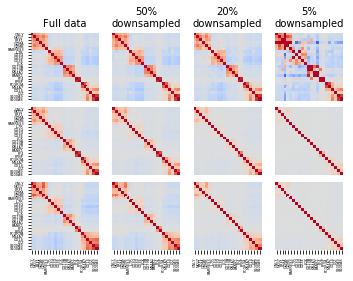

In [127]:
plt.figure(figsize=(6, 4));
plt.subplots_adjust(hspace=0.1, wspace=-0.1)

params = {
    'figure.titlesize':6,
    'xtick.labelsize':3.5,
    'ytick.labelsize':3.5}
pylab.rcParams.update(params)

for idx, dropout in enumerate([1, 0.5, 0.2, 0.05]):
    #dropout = 0.05

    full_ifn_adata_sampled = full_ifn_adata.copy()
    #full_ifn_adata_sampled.X = full_ifn_adata_sampled.X.toarray().astype(int)

    ifn_adata_sampled = ifn_adata.copy()
    ifn_adata_sampled.X = ifn_adata_sampled.X.toarray().astype(int)
    ifn_adata_sampled.X = stats.binom.rvs(ifn_adata_sampled.X, p=dropout)

    # Compute the 3k gene dataset to compute q^2
    all_gene_estimator = scmemo.SingleCellEstimator(
        adata=ifn_adata_sampled, 
        group_label='cell',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.1*dropout)
    all_gene_estimator.compute_observed_moments()
    all_gene_estimator.estimate_beta_sq(tolerance=5)
    
    # Prepare the marker gene AnnData object
    marker_gene_adata_sampled = full_ifn_adata[:, marker_genes].copy()
    marker_gene_adata_sampled.X = marker_gene_adata_sampled.X.toarray().astype(int)
    marker_gene_adata_sampled.X = stats.binom.rvs(marker_gene_adata_sampled.X, p=dropout)
    marker_gene_adata_sampled.obs['PBMC'] = 'Y'
    marker_gene_adata_sampled_norm = marker_gene_adata_sampled.copy()
    marker_gene_adata_sampled_norm.X = marker_gene_adata_sampled_norm.X / (dropout * marker_gene_adata_sampled_norm.obs['n_counts'].values).reshape(-1, 1)*1e4
    sc.pp.log1p(marker_gene_adata_sampled_norm)
    
    # Estimate using scMeMo using the q^2 computed above
    estimator = scmemo.SingleCellEstimator(
        adata=marker_gene_adata_sampled, 
        group_label='PBMC',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.1*dropout)
    estimator.compute_observed_moments()
    estimator.beta_sq = all_gene_estimator.beta_sq
    estimator.estimate_1d_parameters()
    estimator.estimate_2d_parameters(
        gene_list_1=marker_genes,
        gene_list_2=marker_genes)

    # Fit a correlation matrix
    estimated_corr_mat = estimator.parameters['Y']['corr'].toarray()
    estimated_corr_mat = np.clip(estimated_corr_mat, -1, 1)
    raw_corr_mat = np.corrcoef(marker_gene_adata_sampled.X, rowvar=False)
    norm_corr_mat = np.corrcoef(marker_gene_adata_sampled_norm.X, rowvar=False)
    estimated_corr_mat = pd.DataFrame(estimated_corr_mat, index=marker_genes, columns=marker_genes)
    raw_corr_mat = pd.DataFrame(raw_corr_mat, index=marker_genes, columns=marker_genes)
    norm_corr_mat = pd.DataFrame(norm_corr_mat, index=marker_genes, columns=marker_genes)

    plt.subplot(3, 4, idx + 1);
    sns.heatmap(estimated_corr_mat, cmap='coolwarm', cbar=False,
        xticklabels=False, yticklabels=False if idx > 0 else True, center=0, square=True)
    plt.title('{}%\ndownsampled'.format(int(dropout*100)) if dropout < 1 else 'Full data')
    
    plt.subplot(3, 4, idx + 5);
    sns.heatmap(raw_corr_mat, cmap='coolwarm',cbar=False,
        xticklabels=False, yticklabels=False if idx > 0 else True, center=0, square=True)
    
    plt.subplot(3, 4, idx + 9);
    sns.heatmap(norm_corr_mat, cmap='coolwarm',cbar=False,
        xticklabels=True, yticklabels=False if idx > 0 else True, center=0, square=True)
plt.savefig('marker_correlations_ctrl.pdf')

### Marker correlations for control

In [128]:
ifn_adata = sc.read(data_path + 'interferon_highcount.raw.h5ad')
ifn_adata = ifn_adata[:, ifn_adata.var.index.map(lambda x: x[:2] != 'HB')]
ifn_adata = ifn_adata[ifn_adata.obs.stim == 'stim', :].copy()
ifn_adata.obs['cell_type'] = (ifn_adata.obs['cell'].astype(str) + ' - ' + ifn_adata.obs['stim'].astype(str)).astype('category')


In [129]:
marker_genes = [
    'GNLY', 'NKG7', 'PRF1', 'GZMA', 'GZMB', 'RARRES3',
    'IL7R', 'CD3G', 'CD3D', 'CD3E', 'LCK',
    'CD79A', 'CD79B','MS4A1', 'BANK1', 
    'PF4', 'PPBP',
    'FCGR3A', 'MS4A7', 
    'CD14', 'LYZ', 'S100A9', 'S100A8',
]

In [130]:
full_ifn_adata = sc.read(data_path + 'interferon.h5ad')
full_ifn_adata = full_ifn_adata[full_ifn_adata.obs.stim == 'stim', :].copy()
full_ifn_adata.obs['n_counts'] = full_ifn_adata.X.sum(axis=1)

In [131]:
marker_gene_adata = full_ifn_adata[:, marker_genes].copy()
marker_gene_adata.X = marker_gene_adata.X.toarray()
marker_gene_adata.obs['PBMC'] = 'Y'

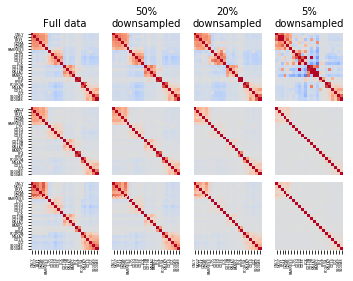

In [132]:
plt.figure(figsize=(6, 4));
plt.subplots_adjust(hspace=0.1, wspace=-0.1)

params = {
    'figure.titlesize':6,
    'xtick.labelsize':3.5,
    'ytick.labelsize':3.5}
pylab.rcParams.update(params)

for idx, dropout in enumerate([1, 0.5, 0.2, 0.05]):
    #dropout = 0.05

    full_ifn_adata_sampled = full_ifn_adata.copy()
    #full_ifn_adata_sampled.X = full_ifn_adata_sampled.X.toarray().astype(int)

    ifn_adata_sampled = ifn_adata.copy()
    ifn_adata_sampled.X = ifn_adata_sampled.X.toarray().astype(int)
    ifn_adata_sampled.X = stats.binom.rvs(ifn_adata_sampled.X, p=dropout)

    # Compute the 3k gene dataset to compute q^2
    all_gene_estimator = scmemo.SingleCellEstimator(
        adata=ifn_adata_sampled, 
        group_label='cell',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.1*dropout)
    all_gene_estimator.compute_observed_moments()
    all_gene_estimator.estimate_beta_sq(tolerance=5)
    
    # Prepare the marker gene AnnData object
    marker_gene_adata_sampled = full_ifn_adata[:, marker_genes].copy()
    marker_gene_adata_sampled.X = marker_gene_adata_sampled.X.toarray().astype(int)
    marker_gene_adata_sampled.X = stats.binom.rvs(marker_gene_adata_sampled.X, p=dropout)
    marker_gene_adata_sampled.obs['PBMC'] = 'Y'
    marker_gene_adata_sampled_norm = marker_gene_adata_sampled.copy()
    marker_gene_adata_sampled_norm.X = marker_gene_adata_sampled_norm.X / (dropout * marker_gene_adata_sampled_norm.obs['n_counts'].values).reshape(-1, 1)*1e4
    sc.pp.log1p(marker_gene_adata_sampled_norm)
    
    # Estimate using scMeMo using the q^2 computed above
    estimator = scmemo.SingleCellEstimator(
        adata=marker_gene_adata_sampled, 
        group_label='PBMC',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.1*dropout)
    estimator.compute_observed_moments()
    estimator.beta_sq = all_gene_estimator.beta_sq
    estimator.estimate_1d_parameters()
    estimator.estimate_2d_parameters(
        gene_list_1=marker_genes,
        gene_list_2=marker_genes)

    # Fit a correlation matrix
    estimated_corr_mat = estimator.parameters['Y']['corr'].toarray()
    estimated_corr_mat = np.clip(estimated_corr_mat, -1, 1)
    raw_corr_mat = np.corrcoef(marker_gene_adata_sampled.X, rowvar=False)
    norm_corr_mat = np.corrcoef(marker_gene_adata_sampled_norm.X, rowvar=False)
    estimated_corr_mat = pd.DataFrame(estimated_corr_mat, index=marker_genes, columns=marker_genes)
    raw_corr_mat = pd.DataFrame(raw_corr_mat, index=marker_genes, columns=marker_genes)
    norm_corr_mat = pd.DataFrame(norm_corr_mat, index=marker_genes, columns=marker_genes)

    plt.subplot(3, 4, idx + 1);
    sns.heatmap(estimated_corr_mat, cmap='coolwarm', cbar=False,
        xticklabels=False, yticklabels=False if idx > 0 else True, center=0, square=True)
    plt.title('{}%\ndownsampled'.format(int(dropout*100)) if dropout < 1 else 'Full data')
    
    plt.subplot(3, 4, idx + 5);
    sns.heatmap(raw_corr_mat, cmap='coolwarm',cbar=False,
        xticklabels=False, yticklabels=False if idx > 0 else True, center=0, square=True)
    
    plt.subplot(3, 4, idx + 9);
    sns.heatmap(norm_corr_mat, cmap='coolwarm',cbar=False,
        xticklabels=True, yticklabels=False if idx > 0 else True, center=0, square=True)
plt.savefig('marker_correlations_stim.pdf')